# Copyright
<pre>
Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérjük
az alábbi szerzőt értesíteni.

2018 (c) Csapó Tamás Gábor (csapot kukac tmit pont bme pont hu),
Gyires-Tóth Bálint, Zainkó Csaba


Original Generative Adversarial Network example from:

Links:
    [GAN Intro] https://github.com/AYLIEN/gan-intro
    [An introduction to Generative Adversarial Networks (with code in TensorFlow)] http://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/
</pre>

In [0]:
# original at https://github.com/AYLIEN/gan-intro

In [1]:
# ffmpeg: szükséges lesz a videó kimentéséhez. érdemes előre telepíteni
!apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.4-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [0]:
# másold ide ennek a tartalmát: https://raw.githubusercontent.com/BME-SmartLab-Education/vitmav45/master/12/GAN_toy_helper.py

import argparse
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
import io
import base64
from IPython.display import HTML

sns.set(color_codes=True)

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

### ezek a függvények az animációhoz szükségesek

def samples(
    model,
    session,
    data,
    sample_range,
    batch_size,
    num_points=10000,
    num_bins=100
):
    '''
    Return a tuple (db, pd, pg), where db is the current decision
    boundary, pd is a histogram of samples from the data distribution,
    and pg is a histogram of generated samples.
    '''
    xs = np.linspace(-sample_range, sample_range, num_points)
    bins = np.linspace(-sample_range, sample_range, num_bins)

    # decision boundary
    db = np.zeros((num_points, 1))
    for i in range(num_points // batch_size):
        db[batch_size * i:batch_size * (i + 1)] = session.run(
            model.D1,
            {
                model.x: np.reshape(
                    xs[batch_size * i:batch_size * (i + 1)],
                    (batch_size, 1)
                )
            }
        )

    # data distribution
    d = data.sample(num_points)
    pd, _ = np.histogram(d, bins=bins, density=True)

    # generated samples
    zs = np.linspace(-sample_range, sample_range, num_points)
    g = np.zeros((num_points, 1))
    for i in range(num_points // batch_size):
        g[batch_size * i:batch_size * (i + 1)] = session.run(
            model.G,
            {
                model.z: np.reshape(
                    zs[batch_size * i:batch_size * (i + 1)],
                    (batch_size, 1)
                )
            }
        )
    pg, _ = np.histogram(g, bins=bins, density=True)

    return db, pd, pg


def plot_distributions(samps, sample_range):
    db, pd, pg = samps
    # db_x = np.linspace(-sample_range, sample_range, len(db))
    p_x = np.linspace(-sample_range, sample_range, len(pd))
    f, ax = plt.subplots(1)
    # ax.plot(db_x, db, label='decision boundary')
    ax.set_ylim(0, 1)
    plt.plot(p_x, pd, label='real data')
    plt.plot(p_x, pg, label='generated data')
    plt.title('1D Generative Adversarial Network')
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    plt.legend()
    plt.show()


def save_animation(anim_frames, anim_path, sample_range):
    f, ax = plt.subplots(figsize=(6, 4))
    f.suptitle('1D Generative Adversarial Network', fontsize=15)
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    ax.set_xlim(-6, 6)
    ax.set_ylim(0, 1.4)
    # line_db, = ax.plot([], [], label='decision boundary')
    line_pd, = ax.plot([], [], label='real data')
    line_pg, = ax.plot([], [], label='generated data')
    frame_number = ax.text(
        0.02,
        0.95,
        '',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes
    )
    ax.legend()

    db, pd, _ = anim_frames[0]
    # db_x = np.linspace(-sample_range, sample_range, len(db))
    p_x = np.linspace(-sample_range, sample_range, len(pd))

    def init():
        # line_db.set_data([], [])
        line_pd.set_data([], [])
        line_pg.set_data([], [])
        frame_number.set_text('')
        return ( line_pd, line_pg, frame_number)

    def animate(i):
        frame_number.set_text(
            'Frame: {}/{}'.format(i, len(anim_frames))
        )
        db, pd, pg = anim_frames[i]
        # line_db.set_data(db_x, db)
        line_pd.set_data(p_x, pd)
        line_pg.set_data(p_x, pg)
        return (line_pd, line_pg, frame_number)

    anim = animation.FuncAnimation(
        f,
        animate,
        init_func=init,
        frames=len(anim_frames),
        blit=True
    )
    anim.save(anim_path, fps=3, extra_args=['-vcodec', 'libx264'])

def show_video(video_file):
    video = io.open(video_file, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii')))


### ezek a függvények a háló összerakásához szükségesek

def linear(input, output_dim, scope=None, stddev=1.0):
    with tf.variable_scope(scope):
        w = tf.get_variable(
            'w',
            [input.get_shape()[1], output_dim],
            initializer=tf.random_normal_initializer(stddev=stddev)
        )
        b = tf.get_variable(
            'b',
            [output_dim],
            initializer=tf.constant_initializer(0.0)
        )
        return tf.matmul(input, w) + b

        
def optimizer(loss, var_list):
    learning_rate = 0.001
    step = tf.Variable(0, trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
        loss,
        global_step=step,
        var_list=var_list
    )
    return optimizer


def log(x):
    '''
    Sometimes discriminiator outputs can reach values close to
    (or even slightly less than) zero due to numerical rounding.
    This just makes sure that we exclude those values so that we don't
    end up with NaNs during optimisation.
    '''
    return tf.log(tf.maximum(x, 1e-5))




### itt kezdjük a játék GAN összerakását



In [0]:
# itt kezdődik a kézzel beírós rész


In [0]:
# adatok eloszlása
class DataDistribution(object):
  def __init__(self):
    self.mu = 4
    self.sigma = 0.5
    
  def sample(self, N):
    samples = np.random.normal(self.mu, self.sigma, N)
    samples.sort()
    return samples

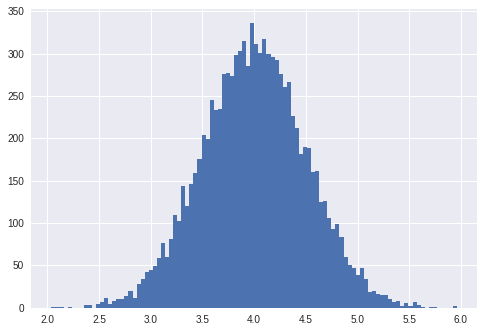

In [4]:
data = DataDistribution()
plt.hist(data.sample(10000), 100)
plt.show()


In [0]:
# generátor eloszlása; range: min/max tartomány
class GeneratorDistribution(object):
  def __init__(self, range):
    self.range = range
    
  def sample(self, N):
    samples = np.linspace(-self.range, self.range, N) + \
              np.random.random(N) * 0.01
    return samples
  

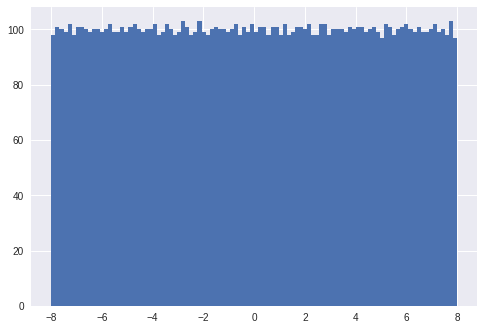

In [6]:
gen = GeneratorDistribution(range=8)
plt.hist(gen.sample(10000), 100)
plt.show()

In [0]:
# generátor: nagyon egyszerű hálózat
def generator(input, h_dim):
  h0 = tf.nn.softplus(linear(input, h_dim, 'g0'))
  h1 = linear(h0, 1, 'g1')
  return h1


In [0]:
# diszkriminátor: erősebb hálózat
def discriminator(input, h_dim):
  h0 = tf.nn.relu(linear(input, h_dim * 2, 'd0'))
  h1 = tf.nn.relu(linear(h0, h_dim * 2, 'd1'))
  h2 = tf.nn.relu(linear(h1, h_dim * 2, 'd2'))
  h3 = tf.sigmoid(linear(h2, 1, 'd3'))
  return h3

In [0]:
class GAN(object):
  
  def __init__(self, batch_size, hidden_size):
    
    # generátor hálózat:
    # látens z-ből mintavételezés, majd neurális hálónak beadás
    with tf.variable_scope('G'):
      self.z = tf.placeholder(tf.float32, shape=(batch_size, 1))
      self.G = generator(self.z, hidden_size)
      
    # diszkriminátor hálózat:
    # célja megkülönböztetni a valódi adatokat (self.x)
    # a generált mintáktól (self.z)
    #
    # két másolat kell belőle, aminek közösek a paraméterei
    # mert TF-ben nem lehet ugyanazt a hálót más bemenettel használni
    self.x = tf.placeholder(tf.float32, shape=(batch_size, 1))
    with tf.variable_scope('D'):
      self.D1 = discriminator(self.x, hidden_size)
    with tf.variable_scope('D', reuse=True):
      self.D2 = discriminator(self.G, hidden_size)
      
    # loss definiálása a D-re és G-re, majd optimalizálás
    # GAN előadásból 2) heurisztikus költség
    self.loss_d = tf.reduce_mean(-log(self.D1) - log(1 - self.D2))
    self.loss_g = tf.reduce_mean(-log(self.D2))
    
    # TF változókból elkülönítjuk a D-hez és G-hez tartozókat
    vars = tf.trainable_variables()
    self.d_params = [v for v in vars if v.name.startswith('D/')]
    self.g_params = [v for v in vars if v.name.startswith('G/')]
    
    # G és D optimizálók
    learning_rate = 0.001
    self.opt_d =  tf.train.AdamOptimizer(learning_rate). \
                    minimize(self.loss_d,
                    global_step = tf.Variable(0, trainable=False),
                    var_list = self.d_params)
    
    self.opt_g =  tf.train.AdamOptimizer(learning_rate). \
                    minimize(self.loss_g,
                    global_step = tf.Variable(0, trainable=False),
                    var_list = self.g_params)
    
      
    

In [0]:
# globális paraméterek
batch_size = 8
hidden_size = 4
num_steps = 5000
anim_path = 'movie.mp4'
anim_every = 100
anim_frames = []


In [0]:
model = GAN(batch_size, hidden_size)


step: 0 (0%) loss_D: 6.631609 loss_G: 0.14502952
step: 100 (2%) loss_D: 6.2817187 loss_G: 0.30736077
step: 200 (4%) loss_D: 6.3805156 loss_G: 0.3288197
step: 300 (6%) loss_D: 6.562632 loss_G: 0.3251536
step: 400 (8%) loss_D: 6.756709 loss_G: 0.3030881
step: 500 (10%) loss_D: 6.9407234 loss_G: 0.15635048
step: 600 (12%) loss_D: 6.700274 loss_G: 0.3753026
step: 700 (14%) loss_D: 6.681842 loss_G: 0.26838246
step: 800 (16%) loss_D: 6.4708166 loss_G: 0.34239578
step: 900 (18%) loss_D: 6.5109653 loss_G: 0.33885908
step: 1000 (20%) loss_D: 6.422392 loss_G: 0.43329212
step: 1100 (22%) loss_D: 0.65433896 loss_G: 6.277893
step: 1200 (24%) loss_D: 0.6811718 loss_G: 6.321288
step: 1300 (26%) loss_D: 0.62315476 loss_G: 6.33681
step: 1400 (28%) loss_D: 0.6039503 loss_G: 6.329634
step: 1500 (30%) loss_D: 0.57539797 loss_G: 6.3982186
step: 1600 (32%) loss_D: 0.5680244 loss_G: 6.40738
step: 1700 (34%) loss_D: 0.53033924 loss_G: 6.4355416
step: 1800 (36%) loss_D: 0.6944251 loss_G: 6.415655
step: 1900 (3

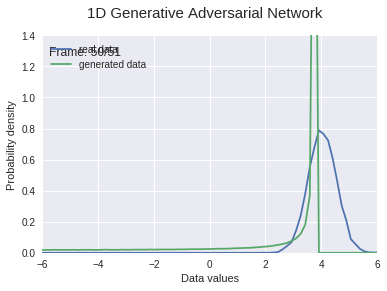

In [12]:
# tanítás
with tf.Session() as session:
  # TF változók inicializálása
  tf.local_variables_initializer().run()
  tf.global_variables_initializer().run()

  for step in range(num_steps + 1):
    # diszkriminátor frissítése
    x = data.sample(batch_size)
    z = gen.sample(batch_size)
    loss_d, _, = session.run([model.loss_d, model.opt_d], {
      model.x: np.reshape(x, (batch_size,1)),
      model.z: np.reshape(z, (batch_size,1))  
    })
    
    # generátor frissítése
    z = gen.sample(batch_size)
    loss_g, _, = session.run([model.loss_g, model.opt_g], {
      model.z: np.reshape(z, (batch_size,1))  
    })
    
   
    # log és animáció
    if step % anim_every == 0:
      print('step:', step, '(' + str(int(step/num_steps*100)) + '%)', 'loss_D:', loss_d, 'loss_G:', loss_g)
      anim_frames.append(samples(model, session, data, gen.range, batch_size))
      
# videó fájlba mentés    
save_animation(anim_frames, anim_path, gen.range)



In [13]:
!ls -al

total 84
drwxr-xr-x 1 root root  4096 Nov 21 09:32 .
drwxr-xr-x 1 root root  4096 Nov 21 06:43 ..
drwxr-xr-x 4 root root  4096 Nov 19 21:43 .config
-rw-r--r-- 1 root root 66171 Nov 21 09:46 movie.mp4
drwxr-xr-x 2 root root  4096 Nov 19 21:53 sample_data


In [14]:
show_video('movie.mp4')

In [0]:
# egy idő után a generátor kedi közelíteni az adatok eloszlását